In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from __future__ import print_function, division

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
print(torch.__version__)

0.4.0


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((-180,180)),
        transforms.RandomAffine(degrees=(-30,30), shear=(-20,20)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5548, 0.4508, 0.3435], [0.2281, 0.2384, 0.2376])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
}

data_dir = '../data/food/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
test_batch = 64
x = 'test'
dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=test_batch,
                                             shuffle=True, num_workers=0)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = torch.device("cpu")

cuda:0


In [6]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f00cab76748>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f00cab76fd0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f00cab76ba8>}


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



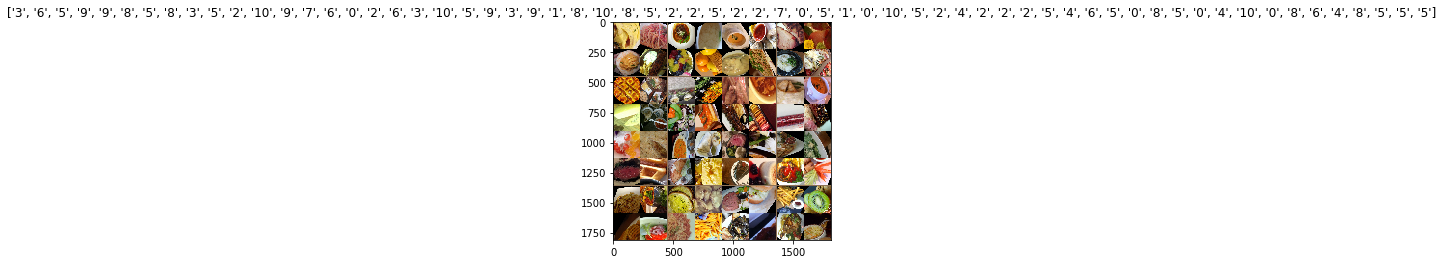

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5548, 0.4508, 0.3435])
    std = np.array([0.2281, 0.2384, 0.2376])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
classes = ('Bread', 'DairyProduct', 'Dessert', 'Egg', 'Friedfood',
    'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', patience=6, verbose=True)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)


In [152]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 1.4795 Acc: 0.5265
val Loss: 0.7857 Acc: 0.7589

Training complete in 2m 52s
Best val Acc: 0.758892


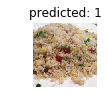

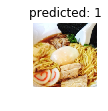

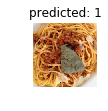

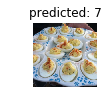

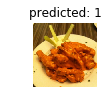

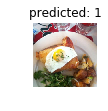

In [12]:
visualize_model(model_ft)

In [13]:
print('==> Saving model..')
#save entire model
model_name = './model-lab5-pytorch-0.4.0-resnet18-food11-' + str(time.time()) + '.pt'
torch.save(model_ft, model_name)
print('Finished Saving')

==> Saving model..
Finished Saving


In [14]:
model_name = './model-lab5-pytorch-0.4.0-resnet18-food11-1544328065.9809835.pt'

In [15]:
print('==> Loading model..')
model_ft = torch.load(model_name)
print('Finished Loading')

==> Loading model..
Finished Loading


In [16]:
######################
# Test the Model
######################
def test(t_data, device):
    print('test data set: %s' %(t_data))
          
    correct = 0
    total = 0
    running_loss = 0.0

    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))

    model_ft.to(device)
    with torch.no_grad():
        for data in dataloaders[t_data]:
            images, labels = data

            #if device == 'cuda':
            #    images = images.cuda(0)
            #    labels = labels.cuda(0)
            #else:
            #    images = images.cpu()
            #    labels = labels.cpu()
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            c = (predicted == labels).squeeze()
            #print(predicted)
            #print(labels.size(0))
            #print(c)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
          % (total, 100 * correct / total, running_loss / total))

    for i in range(11):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [17]:
for test_batch in [2, 4, 8, 16, 32, 64, 128, 256]:
    x = 'test'
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=test_batch,
                                                 shuffle=True, num_workers=0)
    print('batch size: {}'.format(test_batch))
    t0 = time.time()
    test('test', torch.device("cuda:0"))
    pytorch_gpu_time = time.time() - t0
    print('{} seconds'.format(pytorch_gpu_time))

batch size: 2
test data set: test


/home/ccma/n1p1/home/ccma/Chilung/lab5-venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.118
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
44.60714054107666 seconds
batch size: 4
test data set: test
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.059
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
41.56234264373779 seconds
batch size: 8
test data set: test
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.029
Accuracy of Bread : 88 %
Accuracy of

In [18]:
for test_batch in [2, 4, 8, 16, 32, 64, 128, 256]:
    x = 'test'
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=test_batch,
                                                 shuffle=True, num_workers=0)
    print('batch size: {}'.format(test_batch))
    t0 = time.time()
    test('test', torch.device("cpu"))
    pytorch_cpu_time = time.time() - t0
    print('{} seconds'.format(pytorch_cpu_time))

batch size: 2
test data set: test


/home/ccma/n1p1/home/ccma/Chilung/lab5-venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.118
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
240.50005960464478 seconds
batch size: 4
test data set: test
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.059
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
229.77259731292725 seconds
batch size: 8
test data set: test
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.029
Accuracy of Bread : 88 %
Accuracy 

In [19]:
import torch.onnx
help(torch.onnx.export)

Help on function export in module torch.onnx:

export(*args, **kwargs)



In [20]:
from torch.autograd import Variable
import torch
import torchvision
import onnx
import os
import time
from ngraph_onnx.onnx_importer.importer import import_onnx_model
import ngraph as ng
import numpy as np

def torch_to_ngraph(torch_model_name, batch_size = 1):
    dummy_input = torch.randn(batch_size, 3, 224, 224, device='cuda')
    #print(dummy_input.shape)
    model_resnet18 = torch.load(torch_model_name).cuda()
    torch.onnx.export(model_resnet18, dummy_input, 'resnet18.onnx',
                      export_params=True, verbose=False, training=False)
    onnx_filename = 'resnet18.onnx'
    onnx_resnet18 = onnx.load(onnx_filename)
    onnx.checker.check_model(onnx_resnet18)
    #print(onnx.helper.printable_graph(onnx_resnet18.graph))
    ng_models = import_onnx_model(onnx_resnet18)
    #print(ng_models)

    ng_model = ng_models[0]
    runtime = ng.runtime(backend_name='CPU')
    ngraph_resnet18 = runtime.computation(ng_model['output'], *ng_model['inputs'])
    return(ngraph_resnet18)

In [21]:
def test_ngraph(model, t_data):
    print('test data set: %s' %(t_data))
    
    device = torch.device("cpu")
    correct = 0
    total = 0
    running_loss = 0.0

    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))

    with torch.no_grad():
        for data in dataloaders[t_data]:
            images, labels = data
 
            images = images.to(device)
            labels = labels.to(device)
            
            minus_amount = 0
            if(images.size() != torch.Size([test_batch, 3, 224, 224])):
                minus_amount = test_batch - list(images.size())[0]
                print('image size: {}, minus: {}'.format(list(images.size())[0], minus_amount))
                temp_images = torch.zeros([test_batch, 3, 224, 224])
                for i in range(list(images.size())[0]):
                    temp_images[i, :, :, :] = images[i, :, :, :]
                images = temp_images
                temp_labels = torch.zeros([test_batch], dtype=torch.long)
                for i in range(list(labels.size())[0]):
                    temp_labels[i] = labels[i]
                labels = temp_labels
           
            outputs = model(images)
            outputs = torch.from_numpy(outputs)
           
            _, predicted = torch.max(outputs, 1)
        
            total += labels.size(0) - minus_amount
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            c = (predicted == labels).squeeze()

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
          % (total, 100 * correct / total, running_loss / total))

    for i in range(11):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [22]:
test_batch = 64
x = 'test'
dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=test_batch,
                                             shuffle=True, num_workers=0)
ngraph_model = torch_to_ngraph(torch_model_name = './model-lab5-pytorch-0.4.0-resnet18-food11-1544328065.9809835.pt',
                batch_size = test_batch)
t0 = time.time()
test_ngraph(ngraph_model, 'test')
print('{} seconds'.format(time.time() - t0))

test data set: test
image size: 19, minus: 45
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.006
Accuracy of Bread : 78 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
79.72860884666443 seconds


In [23]:
for test_batch in [2, 4, 8, 16, 32, 64, 128, 256]:
    x = 'test'
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=test_batch,
                                                 shuffle=True, num_workers=0)
    ngraph_model = torch_to_ngraph(torch_model_name = './model-lab5-pytorch-0.4.0-resnet18-food11-1544328065.9809835.pt',
                                   batch_size = test_batch)
    print('batch size: {}'.format(test_batch))
    t0 = time.time()
    test_ngraph(ngraph_model, 'test')
    print('{} seconds'.format(time.time() - t0))

batch size: 2
test data set: test
image size: 1, minus: 1
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.119
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
165.80812788009644 seconds
batch size: 4
test data set: test
image size: 3, minus: 1
Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.060
Accuracy of Bread : 88 %
Accuracy of DairyProduct : 81 %
Accuracy of Dessert : 97 %
Accuracy of   Egg : 88 %
Accuracy of Friedfood : 92 %
Accuracy of  Meat : 91 %
Accuracy of Noodles-Pasta : 92 %
Accuracy of  Rice : 98 %
Accuracy of Seafood : 98 %
Accuracy of  Soup : 91 %
Accuracy of Vegetable-Fruit : 97 %
136.33139610290527 seconds
batch size: 8
test data set: test
image size: 3, minus: 5
Accu

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
import matplotlib.patches as mpatches

from torch.autograd import Variable
import torch
import math

import os
import sys
import re
from collections import OrderedDict

def test_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_time = OrderedDict()
    
    with open(fname) as fp:  
        for cnt, line in enumerate(fp):
            print("Line {}: {}".format(cnt, line))
            # batch size: 2
            pattern = re.compile(r"batch size: (\d+)")
            match = pattern.match(line)
            if match:
                batch_size_str, = match.groups()
                print(batch_size_str)
                      
            # Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.004
            pattern = re.compile(r"Accuracy of the network on the (\d+) test images: (\d+.\d+)%, and loss is: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                test_size_str, acc_str, loss_str = match.groups()
                print(test_size_str, acc_str, loss_str)

            # 76.6552894115448 seconds
            pattern = re.compile(r"(\d+.\d+) seconds")
            match = pattern.match(line)
            if match:
                time_str, = match.groups()
                print(time_str)
                print('batch: {:s}, acc: {:s}, time: {:s}'.
                      format(batch_size_str, acc_str, time_str))

                batch = int(math.log(int(batch_size_str), 2))
                acc = float("{:.2f}".format(float(acc_str)))
                time = float("{:.2f}".format(float(time_str)))
                
                dictionary_acc[batch] = acc
                dictionary_time[batch] = time
                    
    return dictionary_acc, dictionary_time

In [25]:
pytorch_gpu_acc, pytorch_gpu_time = test_result("pytorch-gpu-test-result.log")
pytorch_cpu_acc, pytorch_cpu_time = test_result("pytorch-cpu-test-result.log")
ngraph_acc, ngraph_time = test_result("ngraph-test-result.log")

Line 0: batch size: 2

2
Line 1: test data set: test

Line 2: 

Line 3: /home/ccma/n1p1/home/ccma/Chilung/lab5-venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number

Line 4: 

Line 5: Accuracy of the network on the 3347 test images: 92.41%, and loss is: 0.118

3347 92.41 0.118
Line 6: Accuracy of Bread : 88 %

Line 7: Accuracy of DairyProduct : 81 %

Line 8: Accuracy of Dessert : 97 %

Line 9: Accuracy of   Egg : 88 %

Line 10: Accuracy of Friedfood : 92 %

Line 11: Accuracy of  Meat : 91 %

Line 12: Accuracy of Noodles-Pasta : 92 %

Line 13: Accuracy of  Rice : 98 %

Line 14: Accuracy of Seafood : 98 %

Line 15: Accuracy of  Soup : 91 %

Line 16: Accuracy of Vegetable-Fruit : 97 %

Line 17: 41.08022952079773 seconds

41.08022952079773
batch: 2, acc: 92.41, time: 41.08022952079773
Line 18: batch size: 4

4
Line 19: test data set: test



In [26]:
import matplotlib.pyplot as plt
import itertools

def show_test_result(pytorch_gpu_acc, pytorch_gpu_time,
                     pytorch_cpu_acc, pytorch_cpu_time,
                     ngraph_acc, ngraph_time):
    
    print('Pytorch GPU Inference Time')
    print(pytorch_gpu_time)
    print('Pytorch GPU Accuracy')
    print(pytorch_gpu_acc)
    print('Pytorch CPU Inference Time')
    print(pytorch_cpu_time)
    print('Pytorch CPU Accuracy')
    print(pytorch_cpu_acc)
    print('nGraph Inference Time')
    print(ngraph_time)
    print('nGraph Accuracy')
    print(ngraph_acc)
        
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('nGraph Inference Accuracy and Inference Time', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    l1, = ax1.plot(list(pytorch_gpu_time.keys()), list(pytorch_gpu_time.values()), 'r--')
    for i, j in zip(list(pytorch_gpu_time.keys()), list(pytorch_gpu_time.values())):
        ax1.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, 20), textcoords='offset points', color='r', fontsize=20)
    
    l2, = ax1.plot(list(pytorch_cpu_time.keys()), list(pytorch_cpu_time.values()), 'g--')
    for i, j in zip(list(pytorch_cpu_time.keys()), list(pytorch_cpu_time.values())):
        ax1.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, 20), textcoords='offset points', color='g', fontsize=20)
    
    l3, = ax1.plot(list(ngraph_time.keys()), list(ngraph_time.values()), 'b--')
    for i, j in zip(list(ngraph_time.keys()), list(ngraph_time.values())):
        ax1.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, 20), textcoords='offset points', color='b', fontsize=20)
    
    l4, = ax2.plot(list(pytorch_gpu_acc.keys()), list(pytorch_gpu_acc.values()), 'b-')
    for i, j in zip(list(pytorch_gpu_acc.keys()), list(pytorch_gpu_acc.values())):
        ax2.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, -20), textcoords='offset points', color='b', fontsize=20)
    
    l5, = ax2.plot(list(pytorch_cpu_acc.keys()), list(pytorch_cpu_acc.values()), 'b-')
    for i, j in zip(list(pytorch_cpu_acc.keys()), list(pytorch_cpu_acc.values())):
        ax2.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, -20), textcoords='offset points', color='b', fontsize=20)
    
    l6, = ax2.plot(list(ngraph_acc.keys()), list(ngraph_acc.values()), 'b-')
    for i, j in zip(list(ngraph_acc.keys()), list(ngraph_acc.values())):
        ax2.annotate('%s' %j, xy=(i, j), xycoords='data',
                     xytext=(-10, -20), textcoords='offset points', color='b', fontsize=20)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Batch Size (power of 2)', fontsize=20)
    ax1.set_ylabel('Second', fontsize=20, color='r')
    ax2.set_ylabel('Accuracy (%)', fontsize=20, color='b')
    
    ax2.set(ylim=[0, 100])
    
    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3, l4, l5, l6],
               labels=['Pytorch GPU Inference Time', 'Pytorch CPU Inference Time', 'nGraph Inference Time',
                       'Pytorch GPU Accuracy', 'Pytorch CPU Accuracy','nGraph Accuracy'],
               fontsize=20, loc='right')

    plt.show()

Pytorch GPU Inference Time
OrderedDict([(1, 41.08), (2, 39.72), (3, 39.41), (4, 39.81), (5, 38.88), (6, 39.16), (7, 39.11), (8, 39.51)])
Pytorch GPU Accuracy
OrderedDict([(1, 92.41), (2, 92.41), (3, 92.41), (4, 92.41), (5, 92.41), (6, 92.41), (7, 92.41), (8, 92.41)])
Pytorch CPU Inference Time
OrderedDict([(1, 247.47), (2, 237.88), (3, 231.36), (4, 229.07), (5, 227.6), (6, 218.35), (7, 218.24), (8, 221.08)])
Pytorch CPU Accuracy
OrderedDict([(1, 92.41), (2, 92.41), (3, 92.41), (4, 92.41), (5, 92.41), (6, 92.41), (7, 92.41), (8, 92.41)])
nGraph Inference Time
OrderedDict([(1, 174.37), (2, 128.19), (3, 109.84), (4, 89.33), (5, 77.84), (6, 73.42), (7, 75.2), (8, 76.66)])
nGraph Accuracy
OrderedDict([(1, 92.41), (2, 92.41), (3, 92.41), (4, 92.41), (5, 92.41), (6, 92.41), (7, 92.41), (8, 92.41)])


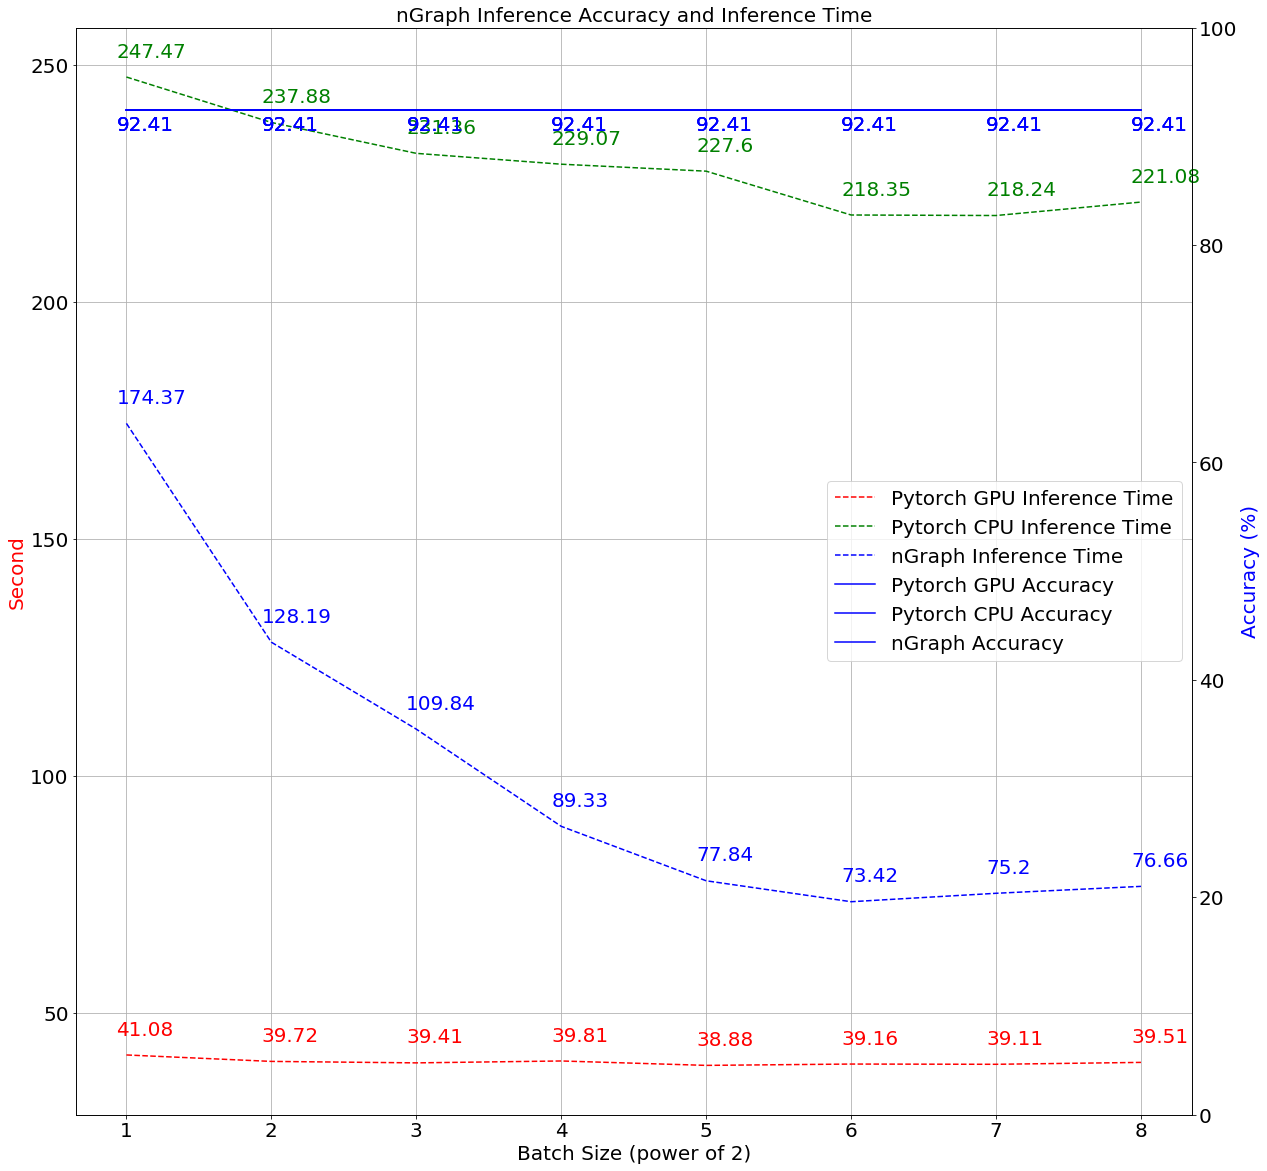

In [27]:
show_test_result(pytorch_gpu_acc, pytorch_gpu_time,
                     pytorch_cpu_acc, pytorch_cpu_time,
                     ngraph_acc, ngraph_time)